In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import networkx as nx
import dowhy
import pandas as pd
from dowhy import CausalModel

style.use('fivethirtyeight') # bmh

import math
import dowhy.datasets, dowhy.plotter

import hyppo
import pingouin as pg
import conditional_independence

from hyppo.independence import Hsic

# the code below simple hides some warnings we don't want to see
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import cdt
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.1.1/bin/Rscript' # for Windows

import numpy as np
from numpy.random import normal

from itertools import combinations


# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

In [16]:
path = "Data/lucas0_text/"
names = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing']

In [17]:
# reading csv files
train =  pd.read_csv(path + 'lucas0_train.data', sep=" ", header = None)
train.drop(11, inplace = True, axis = 1)
train.columns = names
test =  pd.read_csv(path + 'lucas0_test.data', sep=" ", header = None)
test.drop(11, inplace = True, axis = 1)
test.columns = names
target =  pd.read_csv(path + 'lucas0_train.targets', sep=" ", header = None)
# param =  pd.read_csv(path + 'lucas0.param', sep=" ")
train["Target"] = np.array(target)
train["Target"] = train["Target"].apply(lambda x: 0 if x==-1 else x)
train.rename(columns={'Target': 'Lung_Cancer'}, inplace=True)

In [18]:
train.head(10)

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
5,1,1,0,1,0,0,1,1,1,1,1,1
6,1,1,1,1,0,0,0,1,1,0,1,1
7,1,1,1,0,0,0,1,1,1,0,1,1
8,0,0,0,0,0,0,0,1,0,0,0,0
9,1,1,1,1,0,0,1,1,1,1,1,1


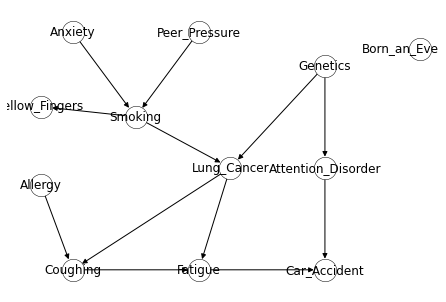

In [19]:
nodes = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics', 'Attention_Disorder','Born_an_Even_Day', 'Car_Accident', 'Fatigue', 'Allergy', 'Coughing', 'Lung_Cancer']
true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
pos = {'Anxiety': (-20, 40),              'Yellow_Fingers': (-25, 18),
         'Peer_Pressure': (0, 40), 'Smoking': (-10, 15), 'Allergy': (-25, -5),
         'Coughing': (-20, -30), 'Lung_Cancer': (5, 0), 'Genetics': (20, 30), 'Attention_Disorder': (20, 0),
         'Fatigue': (0, -30),'Car_Accident': (20, -30), 'Born_an_Even_Day' : (35,35)}
         
true_graph.add_edges_from([('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_Cancer'), 
                  ('Allergy','Coughing'), ('Lung_Cancer','Coughing'), ('Coughing','Fatigue'), ('Lung_Cancer','Fatigue'),
                 ('Genetics','Lung_Cancer'), ('Genetics','Attention_Disorder'), ('Attention_Disorder', 'Car_Accident'), ('Fatigue', 'Car_Accident')])

nx.draw(true_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

### Determine the skeleton
The first step is to determine the skeleton. We start with the complete graph with the number of nodes $p$. Then for $k = 0,1,...,p-2$, consider all pairs of vertices $(i, j)$, and remove the edge between them if $X_i$ and $X_j$ are conditionally independent given some subset of size $k$ of $p\setminus(i, j)$.

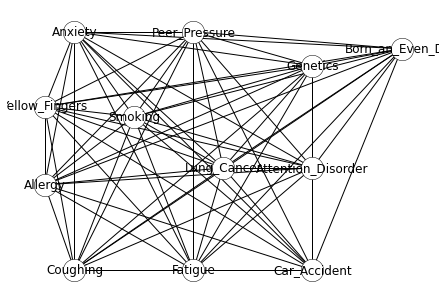

In [20]:
edges = combinations(nodes, 2)
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

In [21]:
train

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


## Removing uncorrelated columns ie edges (takes about 5mn on Intel i7 10th Gen)

In [22]:
def sgs_algo(nodes, G, df, alpha=0.05):
    for size in range(len(nodes)-1):
        print("----------------")
        print(f"Round {size}")
        print("----------------")
        for z in combinations(nodes, size):
            z = list(z)
            for (x, y) in combinations([node for node in nodes if node not in z], 2):
                res = pg.partial_corr(data=df, x=x, y=y, covar=[z]).round(3)
                p_val = res['p-val'].item()
                if p_val > alpha:
                    # edge removal
                    if G.has_edge(x, y): # safety check
                        print(f"removing edge: {(x, y)} with covar={z}")
                        G.remove_edge(x, y)
    return G

new_G = sgs_algo(nodes, G, train, alpha=0.01)

----------------
Round 0
----------------
removing edge: ('Smoking', 'Genetics') with covar=[]
removing edge: ('Smoking', 'Attention_Disorder') with covar=[]
removing edge: ('Smoking', 'Born_an_Even_Day') with covar=[]
removing edge: ('Smoking', 'Car_Accident') with covar=[]
removing edge: ('Smoking', 'Allergy') with covar=[]
removing edge: ('Yellow_Fingers', 'Genetics') with covar=[]
removing edge: ('Yellow_Fingers', 'Attention_Disorder') with covar=[]
removing edge: ('Yellow_Fingers', 'Born_an_Even_Day') with covar=[]
removing edge: ('Yellow_Fingers', 'Car_Accident') with covar=[]
removing edge: ('Yellow_Fingers', 'Allergy') with covar=[]
removing edge: ('Anxiety', 'Peer_Pressure') with covar=[]
removing edge: ('Anxiety', 'Genetics') with covar=[]
removing edge: ('Anxiety', 'Attention_Disorder') with covar=[]
removing edge: ('Anxiety', 'Born_an_Even_Day') with covar=[]
removing edge: ('Anxiety', 'Car_Accident') with covar=[]
removing edge: ('Anxiety', 'Fatigue') with covar=[]
removin

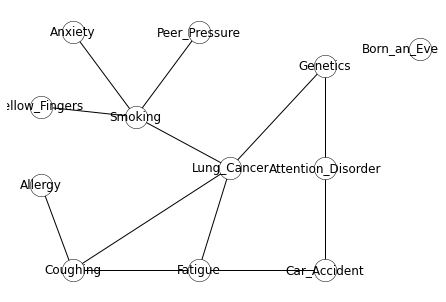

In [23]:
nx.draw(new_G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

## Checking V-Structures

In [24]:
# utility function to transfer undirected graph to directed graph 
# with bi-directional edges with red-color to indicate undirected edges
def to_directed(H):
    D = nx.DiGraph()
    nodes = list(H.nodes())
    edges = []
    for (u, v) in H.edges():
        edges.append((u, v, {"directed": False}))
        edges.append((v, u, {"directed": False}))
    D.add_nodes_from(nodes)
    D.add_edges_from(edges)
    return D

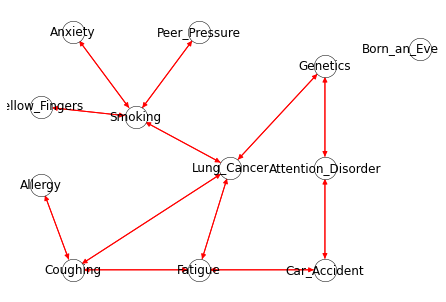

In [25]:
G_directed = to_directed(new_G)
colors = ['black' if G_directed[u][v]['directed']==True else 'r' for u,v in G_directed.edges()]
nx.draw(G_directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

 Considering the high number of nodes, manually determining v-structures and orienting is too time consuming. We are going to use the cdt implementation to make our Causal Discovery

## Using cdt implementation

In [26]:
def get_colors(G):
    edges = G.edges()
    for (x, y) in G.edges():
        if (y, x) in edges:
            # bi-directional edge
            nx.set_edge_attributes(G, {(x, y): {"directed": False}})
        else:
            nx.set_edge_attributes(G, {(x, y): {"directed": True}})
    colors = ['black' if G[u][v]['directed']==True else 'r' for u,v in G.edges()]
    return colors

The CausalDiscoveryTool package offer the possibility to run the PC algorithm.
The default CItest is the Gaussion CI test. However we have the possibility to use different CI tests.
```CI_test = {'binary': "pcalg::binCItest", 
             'discrete': "pcalg::disCItest",
             'hsic_gamma': "kpcalg::kernelCItest",
             'hsic_perm': "kpcalg::kernelCItest",
             'hsic_clust': "kpcalg::kernelCItest",
             'gaussian': "pcalg::gaussCItest",
             'rcit': "RCIT:::CItest",
             'rcot': "RCIT:::CItest"}
             
```

The data being binary, we use the discrete CI test.

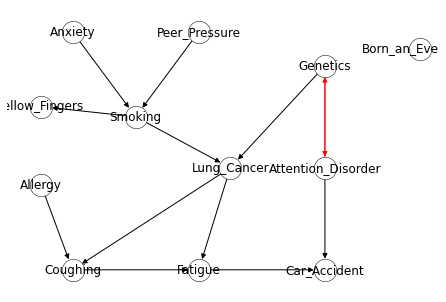

In [27]:
model_pc = cdt.causality.graph.PC(CItest="discrete", alpha=0.01)
created_graph = model_pc.create_graph_from_data(train)
colors = get_colors(created_graph)
nx.draw(created_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

As we can see, the resulting graph from our data is almost the exact one! Only the edge between Genetics and Attention Disorder has not been directed.